## Nongaussian data assimilation
Run a nongaussian twin experiment with Lorenz-63, for different 3D methods (direct assimilation of observations).

In [65]:
# Basic modules
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import time

# Lorenz-63 and DA methods
import sys
sys.path.append("../Models/")
sys.path.append("../DataAssimilation/")
import mod_L63 as L63
import mod_variationalDA as var
import mod_KalmanDA as kf
import mod_MLEF as mlef
import mod_DA_general as da

### Options for data assimilation run

In [66]:
# Options for DA run
da_method = 'KF'                 # DA method, either '3DVAR', 'KF', or 'MLEF'
period_obs = 50                     # Observation period, in number of time steps
obs_vars = 'xyz'                     # Observed variables, either 'xy', or 'xyz'
var_obs = 1.0                       # Variance of the observations
n_e = 3                             # Number of ensemble members (only for MLEF)
ml_method = 'array'                 # Nongaussian decision function, either  
                                    #   'array',    selection based on observations before DA run
                                    #   'function', selection from decision function every DA window
ml_file = './data/kNN_l63_w12_s1.28.pkl'  # Location of the trained ML model
seed = None                         # Seed for random number generator, can be set to None
t_max = 250.0                        # End time of the Lorenz-63 run
SV_init = [-5.0,-6.0,22.0]          # Initial values of the Lorenz-63 run

### Nature run and generating observations

We use the Lorenz-63 model for the twin experiment, which has the following coupled differential equations:
\begin{align*}
\frac{\partial x}{\partial t} =& - \sigma (x - y) \\
\frac{\partial y}{\partial t} =& \rho x - y - z x \\
\frac{\partial z}{\partial t} =& x y - \beta z
\end{align*}

To generate the observations, we make use of the machine-learning model, to decide which distribution to sample the $z$-variable from. Before running this example, the machine learning model should be trained by running `train_ML_L63.py`. 

In [67]:
# Load the machine learning model
with open(ml_file,'rb') as f:
    clf = pickle.load(f)
    scaler = pickle.load(f)
    info = pickle.load(f)
    p = info['p']               # Parameters of L63, typically (10,28,8/3)
    dt = info['dt']             # Time step of L63

# Nature run
t_eval = np.arange(0.0, t_max, dt)  # Evaluation time
t, SV = L63.sol_l63([0.0, t_max], SV_init, p, t_eval, 'RK45')
xi_SV = np.nanmax(SV[2,:])+5.0      # Parameter of the reverse lognormal distribution

In [68]:
# Create observation operator
n_SV = 3
if da_method == 'MLEF':
    if obs_vars == 'xyz':
        def obs_h(x):
            return x
        n_obs = 3
    if obs_vars == 'xy':
        def obs_h(x):
            return x[:2]
        n_obs = 2
elif (da_method == '3DVAR') or (da_method == 'KF'):
    if obs_vars == 'xyz':
        n_obs = 3
        obs_h = np.eye(n_SV)
    if obs_vars == 'xy':
        n_obs = 2
        obs_h = np.zeros((n_obs,n_SV))
        obs_h[0,0] = 1.0
        obs_h[1,1] = 1.0
else:
    raise RuntimeError("DA method not recognized.")

# Predict distribution from which to sample z-variable
if obs_vars == 'xyz':
    # Predict distribution from nature run
    X_data = scaler.transform(np.transpose(SV[:2,:]))
    z_pred = clf.predict(X_data)
    # Define observation times when lognormal or reverse lognormal noise should be added
    ln_vars_ML = []
    rl_vars_ML = []
    for ii in range(t.size):
        if ii % period_obs == 0:
            if z_pred[ii] > 0.5: # Lognormal distribution predicted
                ln_vars_ML.append([2])
                rl_vars_ML.append([])
            elif z_pred[ii] < -0.5: # Reverse lognormal distribution predicted
                ln_vars_ML.append([])
                rl_vars_ML.append([2])
            else: # Gaussian distribution predicted
                ln_vars_ML.append([])
                rl_vars_ML.append([])
if obs_vars == 'xy':
    # If z is not observed, ML model not necessary
    ln_vars_ML = []
    rl_vars_ML = []

# Generate observations
t_obs, y, R = da.gen_obs(t, SV, period_obs, obs_h, var_obs, \
    ln_vars = ln_vars_ML, rl_vars = rl_vars_ML, xi_obs = xi_SV, seed = seed)

# Create initial background error covariance matrix
if da_method == 'MLEF':
    rng = np.random.default_rng(seed)
    sqrtP_a = rng.normal(0,1.0, size = (n_SV,n_e))
elif (da_method == '3DVAR') or (da_method == 'KF'):
    B = L63.create_B_init()
else:
    raise RuntimeError("DA method not recognized.")

### Data assimilation

In [69]:
# DA initial guess
rng = np.random.default_rng(seed)
init_guess = SV_init + rng.standard_normal(3)

# Model function, of the form x = model(t,x_0)
def model_l63(t, x0):
    _, y = L63.sol_l63([t[0],t[-1]], x0, p, t, meth='RK45')
    return y

# Decision function for lognormal state variables (for a single prediction)
def f_ln_vars(SV):
    X = scaler.transform(SV[:2].reshape(1,-1))
    z_pred = clf.predict(X)
    if z_pred > 0.5:
        return [2]
    else:
        return []
# Decision function for reverse-lognormal state variables (for a single prediction)
def f_rl_vars(SV):
    X = scaler.transform(SV[:2].reshape(1,-1))
    z_pred = clf.predict(X)
    if z_pred < -0.5:
        return [2]
    else:
        return []

# if obs_vars == 'xy':
#     # If z is not observed, it's better to use the function form,
#     # such that the distribution is based on the background state
#     ml_method = 'function'

# Create decision functions/arrays
if ml_method == 'array':
    ln_vars = []
    rl_vars = []
    for ii in range(t_obs.size):
        ln_vars.append(f_ln_vars(y[:2,ii]))
        rl_vars.append(f_rl_vars(y[:2,ii]))
if ml_method == 'function':
    ln_vars = f_ln_vars
    rl_vars = f_rl_vars

# Store different decision functions for different (non)gaussian methods
n_meths = 7
meths = [ \
    'Gaussian ', \
    'Lognormal', \
    'Rev logn ', \
    'G-LogNorm', \
    'G-RevLog ', \
    'All mixed', \
    'noDA     ' \
]

ln_vars_SV_OBJ = np.array([ \
    [],      # Gaussian for all t
    [2],     # Lognormal for all t
    [],      # Reverse Lognormal for all t
    ln_vars, # Gaussian - Lognormal ML
    [],      # Gaussian - Reverse Lognormal ML
    ln_vars, # Gaussian - Lognormal - Reverse Lognormal ML
    [],      # No DA (background run)
], dtype = object)
rl_vars_SV_OBJ = np.array([ \
    [],      # Gaussian for all t
    [],      # Lognormal for all t
    [2],     # Reverse Lognormal for all t
    [],      # Gaussian - Lognormal ML
    rl_vars, # Gaussian - Reverse Lognormal ML
    rl_vars, # Gaussian - Lognormal - Reverse Lognormal ML
    [],      # No DA (background run)
], dtype = object)
if obs_vars == 'xyz':
    ln_vars_obs_OBJ = ln_vars_SV_OBJ
    rl_vars_obs_OBJ = rl_vars_SV_OBJ
elif obs_vars == 'xy':
    ln_vars_obs_OBJ = np.array([[],[],[],[],[],[],[-1.0]], dtype = object)
    rl_vars_obs_OBJ = np.array([[],[],[],[],[],[],[-1.0]], dtype = object)

# Initialize analysis and background state variables
n_t_obs = t_obs.size           # number of observations
n_t = n_t_obs * period_obs + 1 # number of total time steps
X_A = np.empty((n_meths, n_SV, n_t_obs))
X_B = np.empty((n_meths, n_SV, n_t))

for iM in range(n_meths-1):
    t1 = time.time()
    if da_method == '3DVAR':

        varmeth = 'min'             # Method for minimizing, either 'min', or 'root'
        descriptor = 'mode'         # Descriptor to optimize, either 'mode', 'mean', or 'median'
        if descriptor == 'mode':
            l_SV, l_obs = 1.0, 1.0
        elif descriptor == 'mean':
            l_SV, l_obs =-0.5,-0.5
        elif descriptor == 'median':
            l_SV, l_obs = 0.0, 0.0

        X_A[iM,:,:], X_B[iM,:,:], _ = var.var3d( \
            init_guess, t_obs, period_obs, y, obs_h, B, R, \
            model_l63, \
            ln_vars_SV = ln_vars_SV_OBJ[iM], ln_vars_obs = ln_vars_obs_OBJ[iM], \
            rl_vars_SV = rl_vars_SV_OBJ[iM], rl_vars_obs = rl_vars_obs_OBJ[iM], \
            xi_SV = xi_SV, xi_obs = xi_SV, \
            method = varmeth, \
            l_SV = l_SV, l_obs = l_obs \
        )

    elif da_method == 'KF':
        
        # Model error covariance matrix
        Q = np.array([ \
            [0.1491, 0.1505, 0.0007], \
            [0.1505, 0.9048, 0.0014], \
            [0.0007, 0.0014, 0.9180] \
        ])

        X_A[iM,:,:], X_B[iM,:,:], _ = kf.kalman_filter( \
            init_guess, t_obs, period_obs, y, obs_h, B, R, Q, \
            model_l63, \
            ln_vars_SV = ln_vars_SV_OBJ[iM], ln_vars_obs = ln_vars_obs_OBJ[iM], \
            rl_vars_SV = rl_vars_SV_OBJ[iM], rl_vars_obs = rl_vars_obs_OBJ[iM], \
            xi_SV = xi_SV, xi_obs = xi_SV \
        )

    elif da_method == 'MLEF':
        
        X_A[iM,:,:], X_B[iM,:,:], _ = mlef.MLEF( \
            init_guess, t_obs, period_obs, n_e, y, obs_h, sqrtP_a, R, \
            model_l63, \
            ln_vars_SV = ln_vars_SV_OBJ[iM], ln_vars_obs = ln_vars_obs_OBJ[iM], \
            rl_vars_SV = rl_vars_SV_OBJ[iM], rl_vars_obs = rl_vars_obs_OBJ[iM], \
            xi_SV = xi_SV, xi_obs = xi_SV \
        )

    else:
        raise RuntimeError("DA method not recognized.")
    t2 = time.time()
    print("Finished "+meths[iM]+" "+da_method+" run, t = "+str(t2-t1))
    
# Background run
iM += 1
dt_obs = t_obs[1] - t_obs[0] # Assuming evenly spaced observations
t_true = np.linspace(t_obs[0],t_obs[-1] + dt_obs, n_t) # Assuming one prediction window
X_B[iM,:,:] = model_l63(t_true, init_guess)
X_A[iM,:,:] = X_B[iM,:,:-1:period_obs]

Finished Gaussian  KF run, t = 1.3924281597137451
Finished Lognormal KF run, t = 1.4414703845977783
Finished Rev logn  KF run, t = 1.3422465324401855
Finished G-LogNorm KF run, t = 1.4242157936096191
Finished G-RevLog  KF run, t = 1.3694844245910645
Finished All mixed KF run, t = 1.401258945465088


### Plot results

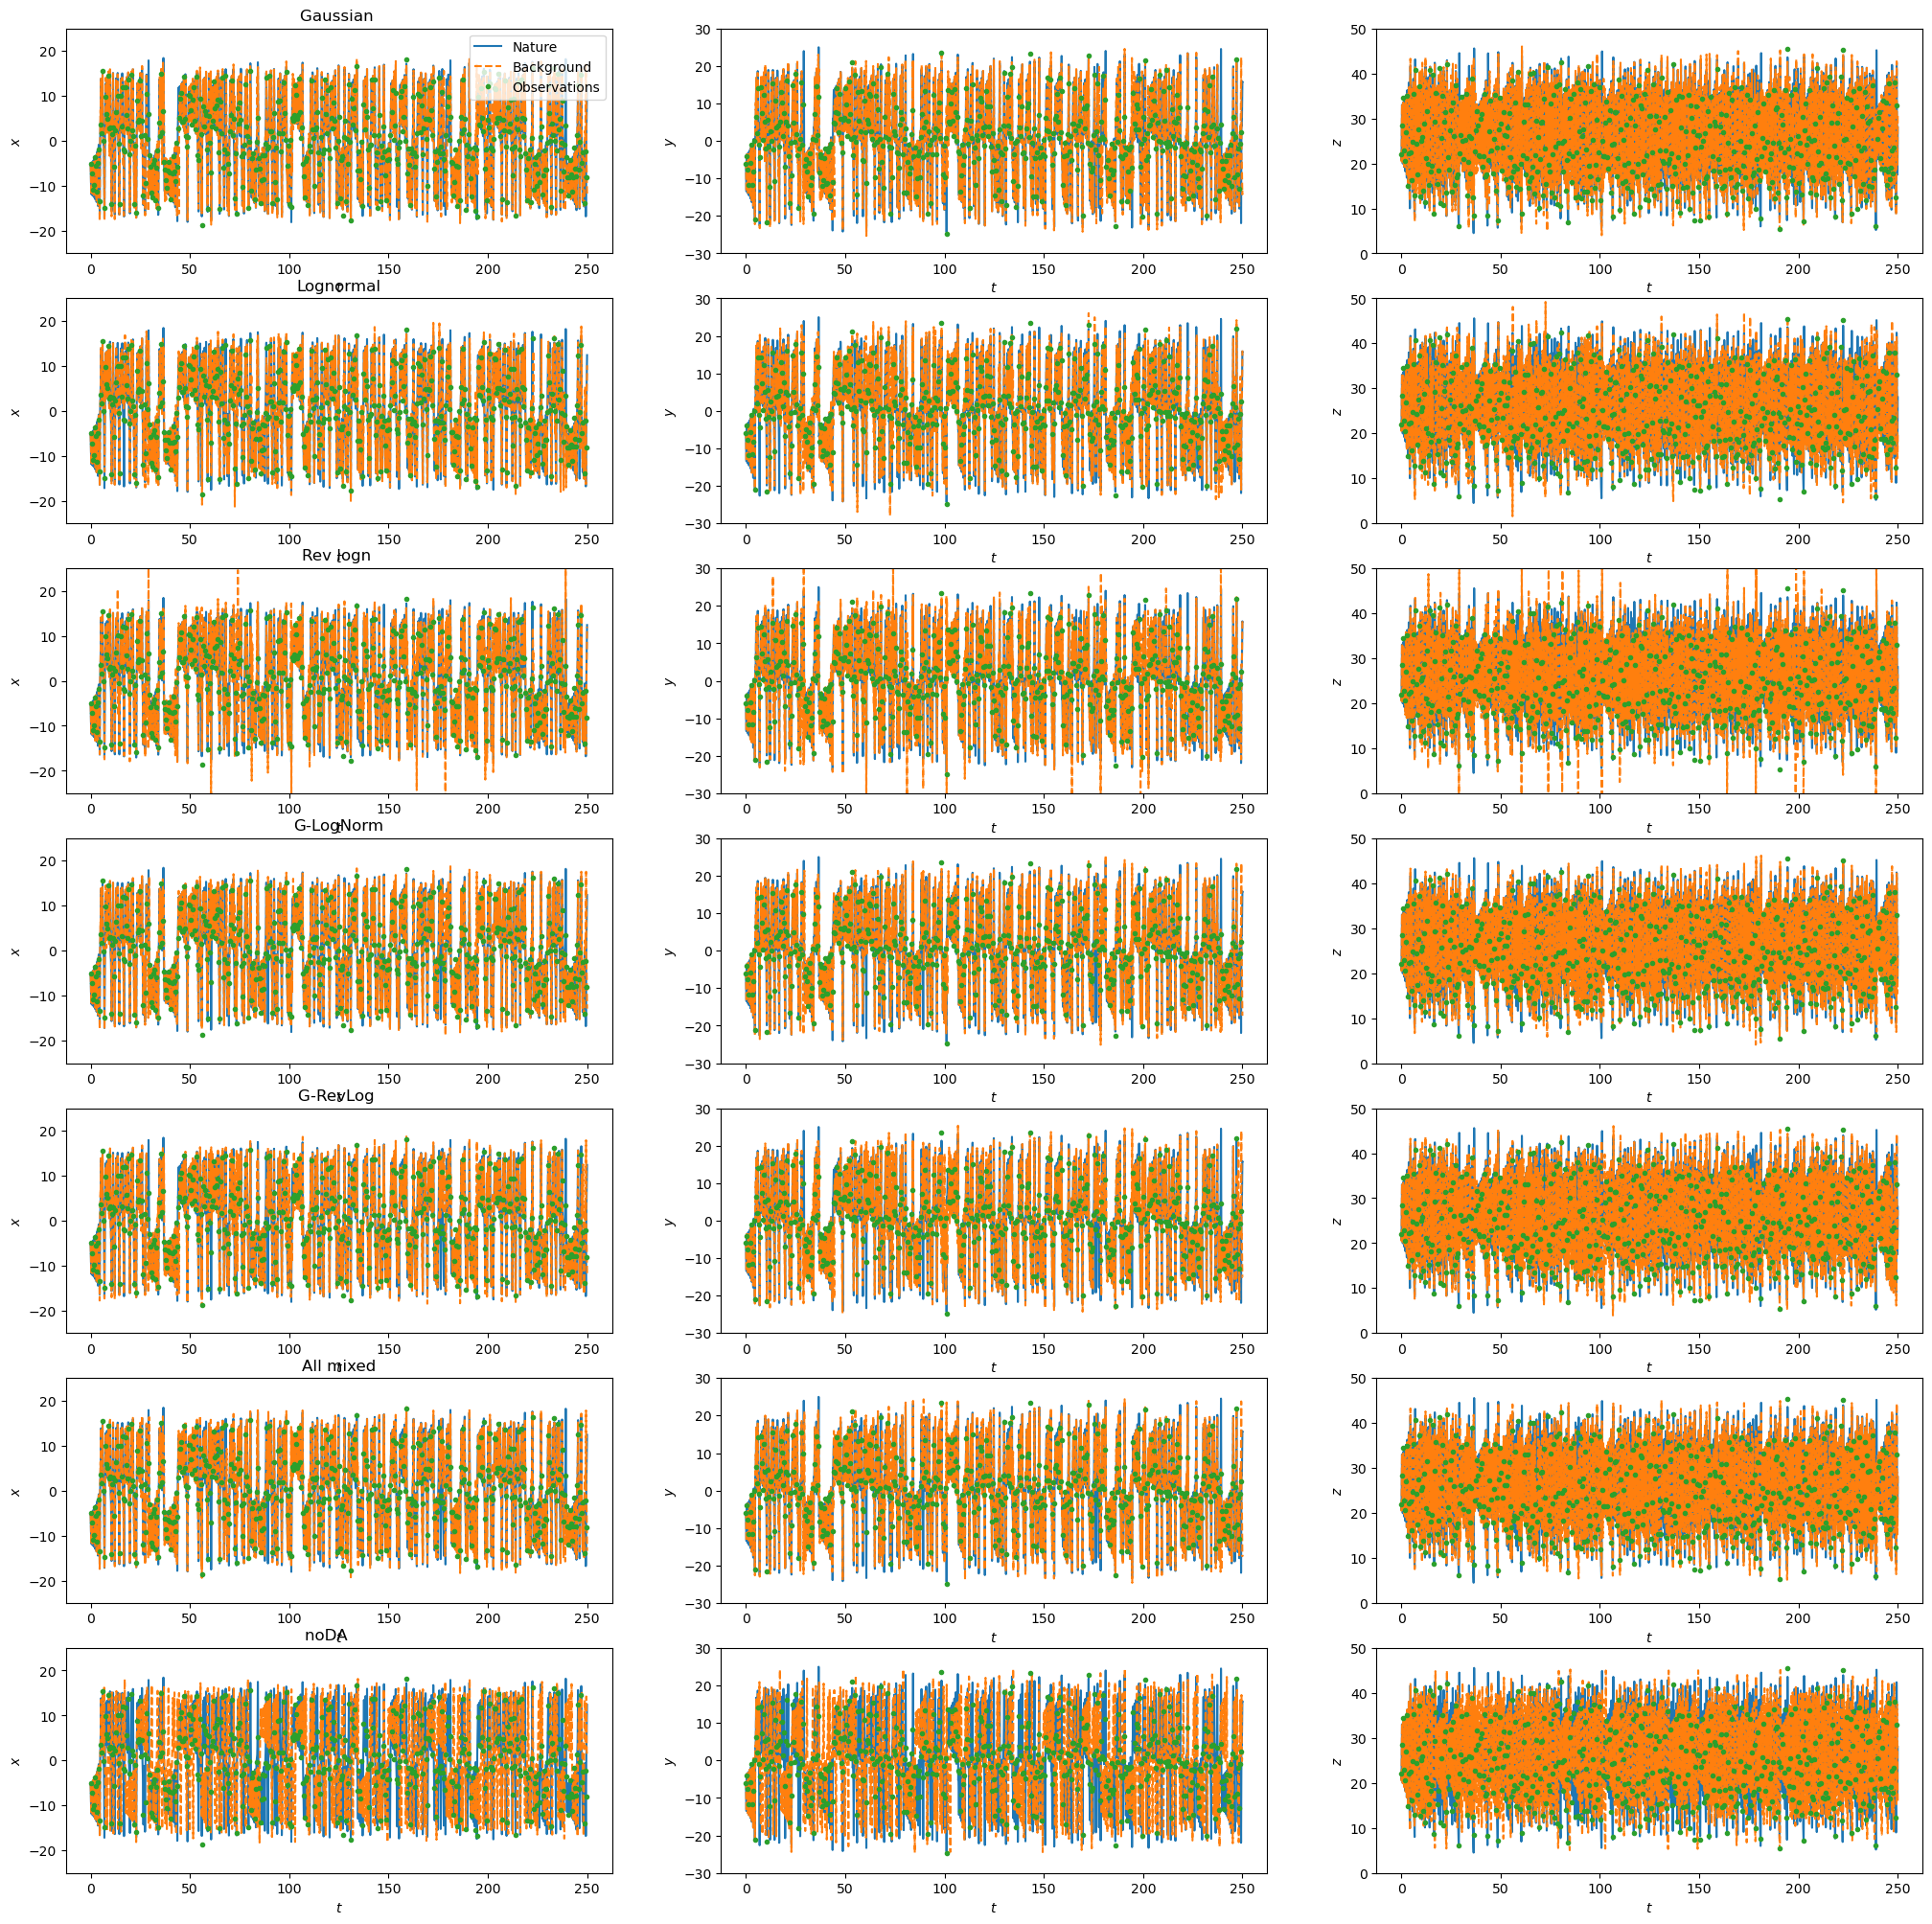

In [70]:
fig, ax = plt.subplots(n_meths,3,figsize=(25, 25))
vars = ['$x$', '$y$', '$z$']
for iMeth in range(n_meths):
    for jj in range(3):
        # True state
        ax[iMeth,jj].plot(t,SV[jj,:],label = 'Nature')
    
        # Background state
        ax[iMeth,jj].plot(t,X_B[iMeth,jj,:-1],'--',label = 'Background')

        # Observations
        if not (jj==2 and obs_vars == 'xy'):
            ax[iMeth,jj].plot(t_obs,y[jj,:],'.',label = 'Observations')

        # # Analysis
        # ax[iMeth,jj].plot(t_obs,X_A[iMeth,jj,:],'.',label = 'Analysis')

        ax[iMeth,jj].set_xlabel('$t$')
        ax[iMeth,jj].set_ylabel(vars[jj])
    ax[iMeth,0].set_title(meths[iMeth])
    ax[iMeth,0].set_ylim(-25,25)
    ax[iMeth,1].set_ylim(-30,30)
    ax[iMeth,2].set_ylim(0,50)
ax[0,0].legend()

### Performance statistics

In [71]:
RMSE_A = np.empty(n_meths)
RMSE_B = np.empty(n_meths)
print("Root mean square errors for "+da_method)
for iM in range(n_meths):
    RMSE_A[iM] = da.rmse(SV, X_A[iM,:,:], period_DA=period_obs)
    RMSE_B[iM] = da.rmse(SV, X_B[iM,:,:-1])

    print(meths[iM]+ \
        ': r_a = '+format(np.round(RMSE_A[iM],3),".3f")+ \
        ', r_b = '+format(np.round(RMSE_B[iM],3),".3f"))

def rmedianse(SV_true,SV_DA,period_DA = 1):
    # return np.sqrt(np.nanmedian((SV_true[:,::period_DA] - SV_DA)**2))
    # return np.nanmean(np.abs(SV_true[:,::period_DA] - SV_DA))
    return np.nanmean(np.abs(SV_true[:,::period_DA] - SV_DA))

print("")
RmSE_A = np.empty(n_meths)
RmSE_B = np.empty(n_meths)
print("Root median square errors for "+da_method)
for iM in range(n_meths):
    RmSE_A[iM] = rmedianse(SV, X_A[iM,:,:], period_DA=period_obs)
    RmSE_B[iM] = rmedianse(SV, X_B[iM,:,:-1])

    print(meths[iM]+ \
        ': r_a = '+format(np.round(RmSE_A[iM],3),".3f")+ \
        ', r_b = '+format(np.round(RmSE_B[iM],3),".3f"))

Root mean square errors for KF
Gaussian : r_a = 2.419, r_b = 4.093
Lognormal: r_a = 3.081, r_b = 4.021
Rev logn : r_a = 3.224, r_b = 4.252
G-LogNorm: r_a = 2.295, r_b = 3.915
G-RevLog : r_a = 2.677, r_b = 4.625
All mixed: r_a = 2.168, r_b = 3.843
noDA     : r_a = 11.847, r_b = 12.012

Root median square errors for KF
Gaussian : r_a = 1.195, r_b = 1.958
Lognormal: r_a = 1.534, r_b = 2.206
Rev logn : r_a = 1.665, r_b = 2.430
G-LogNorm: r_a = 1.163, r_b = 1.886
G-RevLog : r_a = 1.379, r_b = 2.300
All mixed: r_a = 1.150, r_b = 1.913
noDA     : r_a = 9.444, r_b = 9.505
